# "How many waveforms do I need?" 
Understanding how the architecture of seismic datasets affects the performance of deep learning models for automated phase-picking.

The use of deep learning (DL) in earthquake detection and phase-picking tasks has produced transformative results in recent years. Driven by large seismic datasets, DL pickers hold much promise in improving the accuracy of automated picks. However, the regionalization of seismic velocity and attenuation models makes the application of pre-established phase pickers to new target regions challenging if the input seismic data distribution is not reflected in the original training datasets. Furthermore, transfer learning of DL pickers may not be possible due to the lack of reliable human-reviewed waveforms for training. Perhaps the greatest challenge is that seismologists have no a priori knowledge of the number of waveforms required for model training to achieve their desired phase-picking accuracy and model residuals, or which proposed DL pickers can be applied directly to a new target region without re-training. In this study, we explore the issues of DL model performance by investigating the effect of increasing training sample sizes and examining different deployment settings applied to new data. To this end, we retrain two of the most popular DL pickers, PhaseNet and EQTransformer, using training datasets of various size and then test the phase picking accuracy with the same validation set. From this study, we gain insight into how many waveforms should be included in a new DL project and which additional factors (e.g., data preprocessing and standardization, picking method, tectonic setting, etc.) might affect training and model performance. Our study provides a guide for determining the optimal size of the training data set and model selection for future studies.


### Authors

- Hao Mai, Department of Earth and Environmental Sciences, University of Ottawa, Ottawa, Canada - [Email](mailto:hmai090@uottawa.ca)
- Pascal Audet, Department of Earth and Environmental Sciences, University of Ottawa, Ottawa, Canada
- H.K. Claire Perry, Canadian Hazards Information Service, Natural Resources Canada, Ottawa, Canada
- Clément Estève, Department of Meteorology and Geophysics, University of Vienna, Vienna, Austria

### Citation

If you find this work useful in your research, please consider citing our paper:

Mai, H., Audet, P., Perry, H.K.C., Mousavi, S.M., & Zhang, Q. (2023). Blockly earthquake transformer: A deep learning platform for custom phase picking. Artificial Intelligence in Geosciences. https://doi.org/10.1016/j.aiig.2023.05.003

```bibtex
@article{mai2023blockly,
  title={Blockly earthquake transformer: A deep learning platform for custom phase picking},
  author={Mai, Hao and Audet, Pascal and Perry, H.K. Claire and Mousavi, S. Mostafa and Zhang, Q},
  journal={Artificial Intelligence in Geosciences},
  year={2023},
  doi={10.1016/j.aiig.2023.05.003}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seisbench
import seisbench.models as sbm
import pandas as pd
import os
from obspy import read
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy
import matplotlib.pyplot as plt
import pygmt
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

`cache_root` saves datasets, i.e., `HDF5` files and `csv` files in each specific `dataset name`. For simplicity, we use `DummayDatset` to represent the path to the new created `Mackenzie` dataset.

In [3]:
# print seisbench root
print(seisbench.cache_root)

/Users/hao/.seisbench


# Load Dataset

## Load Mackenzie Dataset

In [2]:
import seisbench.data as sbd
data = sbd.DummyDataset()
train, dev, test = data.train_dev_test()

### Visualize the dataset

In [3]:
# load Mackenzie metadata for map
df = data.metadata.copy()
df

source_id           source_origin_time  \
0      evid20190829.0421001  2019-08-29T04:21:33.900000Z   
1      evid20160818.0708002  2016-08-18T07:08:58.040000Z   
2      evid20170323.1235001  2017-03-23T12:35:57.060000Z   
3      evid20210611.0705004  2021-06-11T07:05:15.940000Z   
4      evid20161015.0823004  2016-10-15T08:23:53.140000Z   
...                     ...                          ...   
54494  evid20200322.0627001  2020-03-22T06:27:55.230000Z   
54495  evid20150611.0243001  2015-06-11T02:43:18.340000Z   
54496  evid20200221.0116001  2020-02-21T01:16:12.000000Z   
54497  evid20200314.2357001  2020-03-14T23:57:40.140000Z   
54498  evid20210419.1400001  2021-04-19T14:00:15.720000Z   

       source_origin_uncertainty_sec  source_latitude_deg  \
0                                NaN              67.9713   
1                                NaN              64.9762   
2                                NaN              62.0021   
3                                NaN              66.7541   
4                                NaN              65.3289   
...                              ...                  ...   
54494                            NaN              66.1164   
54495                            NaN              67.4385   
54496                            NaN              65.3397   
54497                            NaN              66.1601   
54498                            NaN              65.4342   

       source_latitude_uncertainty_km  source_longitude_deg  \
0                                 NaN             -136.2442   
1                                 NaN             -130.3027   
2                                 NaN             -124.0063   
3                                 NaN             -135.8841   
4                                 NaN             -134.7377   
...                               ...                   ...   
54494                             NaN             -135.3623   
54495                             NaN             -132.9716   
54496                             NaN             -133.6917   
54497                             NaN             -135.4320   
54498                             NaN             -137.2103   

       source_longitude_uncertainty_km  source_depth_km  \
0                                  NaN             8.84   
1                                  NaN            30.00   
2                                  NaN             5.00   
3                                  NaN            10.00   
4                                  NaN            15.00   
...                                ...              ...   
54494                              NaN            14.96   
54495                              NaN             1.00   
54496                              NaN             0.00   
54497                              NaN            36.01   
54498                              NaN             7.04   

       source_depth_uncertainty_km  source_magnitude  ...  \
0                              NaN               2.2  ...   
1                              NaN               3.1  ...   
2                              NaN               2.7  ...   
3                              NaN               4.3  ...   
4                              NaN               3.0  ...   
...                            ...               ...  ...   
54494                          NaN               2.8  ...   
54495                          NaN               2.6  ...   
54496                          NaN               3.5  ...   
54497                          NaN               2.6  ...   
54498                          NaN               1.3  ...   

       trace_Pn_arrival_sample trace_Pn_status trace_Sn_arrival_sample  \
0                          NaN             NaN                     NaN   
1                       5999.0          manual                     NaN   
2                        141.0          manual                  5999.0   
3                       6000.0          manual                     Na

In [4]:
df.columns

Index(['source_id', 'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude_deg', 'source_latitude_uncertainty_km',
       'source_longitude_deg', 'source_longitude_uncertainty_km',
       'source_depth_km', 'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_uncertainty', 'source_magnitude_type',
       'source_magnitude_author', 'split', 'station_network_code',
       'station_code', 'trace_channel', 'station_location_code',
       'trace_sampling_rate_hz', 'trace_start_time', 'trace_P_arrival_sample',
       'trace_P_status', 'trace_S_arrival_sample', 'trace_S_status',
       'trace_name', 'trace_Pn_arrival_sample', 'trace_Pn_status',
       'trace_Sn_arrival_sample', 'trace_Sn_status', 'trace_Sg_arrival_sample',
       'trace_Sg_status', 'trace_Pg_arrival_sample', 'trace_Pg_status',
       'trace_chunk', 'trace_component_order'],
      dtype='object')

## Map

In [5]:
#rename columns for plotting
df.rename(columns={'station_code': 'station'}, inplace=True)
df.rename(columns={'trace_start_time': 'arrival_time'}, inplace=True)
df.rename(columns={'source_origin_time': 'origin time'}, inplace=True)
df.rename(columns={'source_latitude_deg': 'srcLat (deg)'}, inplace=True)
df.rename(columns={'source_longitude_deg': 'srcLon (deg)'}, inplace=True)

### Prepare Station Information for Publishable Map

In [6]:
station_df = df.drop_duplicates(['station'], keep = 'first')
print(f"Total stations: {len(station_df)}")

Total stations: 277


In [7]:
station_df

source_id                  origin time  \
0      evid20190829.0421001  2019-08-29T04:21:33.900000Z   
1      evid20160818.0708002  2016-08-18T07:08:58.040000Z   
2      evid20170323.1235001  2017-03-23T12:35:57.060000Z   
3      evid20210611.0705004  2021-06-11T07:05:15.940000Z   
4      evid20161015.0823004  2016-10-15T08:23:53.140000Z   
...                     ...                          ...   
49249  evid20171222.0800012  2017-12-22T08:00:13.450000Z   
49568  evid20171222.0800012  2017-12-22T08:00:13.450000Z   
49874  evid20151021.2033002  2015-10-21T20:33:24.350000Z   
51647  evid20171222.0800012  2017-12-22T08:00:13.450000Z   
53615  evid20171222.0800012  2017-12-22T08:00:13.450000Z   

       source_origin_uncertainty_sec  srcLat (deg)  \
0                                NaN       67.9713   
1                                NaN       64.9762   
2                                NaN       62.0021   
3                                NaN       66.7541   
4                                NaN       65.3289   
...                              ...           ...   
49249                            NaN       65.4678   
49568                            NaN       65.4678   
49874                            NaN       64.2320   
51647                            NaN       65.4678   
53615                            NaN       65.4678   

       source_latitude_uncertainty_km  srcLon (deg)  \
0                                 NaN     -136.2442   
1                                 NaN     -130.3027   
2                                 NaN     -124.0063   
3                                 NaN     -135.8841   
4                                 NaN     -134.7377   
...                               ...           ...   
49249                             NaN     -134.1019   
49568                             NaN     -134.1019   
49874                             NaN     -130.9016   
51647                             NaN     -134.1019   
53615                             NaN     -134.1019   

       source_longitude_uncertainty_km  source_depth_km  \
0                                  NaN             8.84   
1                                  NaN            30.00   
2                                  NaN             5.00   
3                                  NaN            10.00   
4                                  NaN            15.00   
...                                ...              ...   
49249                              NaN             1.52   
49568                              NaN             1.52   
49874                              NaN             1.00   
51647                              NaN             1.52   
53615                              NaN             1.52   

       source_depth_uncertainty_km  source_magnitude  ...  \
0                              NaN              2.20  ...   
1                              NaN              3.10  ...   
2                              NaN              2.70  ...   
3                              NaN              4.30  ...   
4                              NaN              3.00  ...   
...                            ...               ...  ...   
49249                          NaN              5.06  ...   
49568                          NaN              5.06  ...   
49874                          NaN              4.70  ...   
51647                          NaN              5.06  ...   
53615                          NaN              5.06  ...   

       trace_Pn_arrival_sample trace_Pn_status trace_Sn_arrival_sample  \
0                          NaN             NaN                     NaN   
1                       5999.0          manual                     NaN   
2                        141.0          manual                  5999.0   
3                       6000.0          manual                     NaN   
4                       6000.0          manual                 11209.0   
...                        ...             ...                     ...   
49249                      

### Check Time Range

In [8]:
df.head(10)
#print the minimum and maximum values of the arruval time
print(f"Minimum arrival time: {df['arrival_time'].min()}")
print(f"Maximum arrival time: {df['arrival_time'].max()}")
# print the total number of events
print(f"Total number of events: {len(df)}")

Minimum arrival time: 2015-01-02T16:54:43.950000Z
Maximum arrival time: 2022-12-31T00:36:08.650000Z
Total number of events: 54499


### Prepare Event Information for Publishable Map

In [9]:
event_df = df.drop_duplicates(['origin time'], keep = 'first')
print(f"Total events: {len(event_df)}")

Total events: 1666


In [32]:
# remove columns that are not needed
station_df = station_df.drop(['srcLat (deg)', 'srcLon (deg)'], axis=1)
# rename columns in ETHZ metadata
station_df.rename(columns={ 'station_latitude_deg':'srcLat (deg)'}, inplace=True)
station_df.rename(columns={ 'station_longitude_deg':'srcLon (deg)'}, inplace=True)

In [19]:
event_df.rename(columns={'source_magnitude':'mag Sol'}, inplace=True)

In [10]:
event_df.describe()

source_origin_uncertainty_sec  srcLat (deg)  \
count                            0.0   1666.000000   
mean                             NaN     65.201050   
std                              NaN      1.511241   
min                              NaN     62.000100   
25%                              NaN     64.476725   
50%                              NaN     65.327700   
75%                              NaN     66.346500   
max                              NaN     67.995300   

       source_latitude_uncertainty_km  srcLon (deg)  \
count                             0.0   1666.000000   
mean                              NaN   -135.786790   
std                               NaN      3.610971   
min                               NaN   -142.818000   
25%                               NaN   -138.227125   
50%                               NaN   -135.758450   
75%                               NaN   -134.433850   
max                               NaN   -124.006300   

       source_longitude_uncertainty_km  source_depth_km  \
count                              0.0      1666.000000   
mean                               NaN         9.463679   
std                                NaN         8.153677   
min                                NaN         0.000000   
25%                                NaN         1.592500   
50%                                NaN         9.450000   
75%                                NaN        14.780000   
max                                NaN       100.000000   

       source_depth_uncertainty_km  source_magnitude  \
count                          0.0       1666.000000   
mean                           NaN          2.353908   
std                            NaN          0.661553   
min                            NaN         -0.000000   
25%                            NaN          1.900000   
50%                            NaN          2.300000   
75%                            NaN          2.800000   
max                            NaN          5.300000   

       source_magnitude_uncertainty  station_location_code  \
count                           0.0                    0.0   
mean                            NaN                    NaN   
std                             NaN                    NaN   
min                             NaN                    NaN   
25%                             NaN                    NaN   
50%                             NaN                    NaN   
75%                             NaN                    NaN   
max                             NaN                    NaN   

       trace_sampling_rate_hz  trace_P_arrival_sample  trace_S_arrival_sample  \
count                  1666.0              397.000000              378.000000   
mean                    100.0             5451.531486             6662.939153   
std                       0.0              743.386968              783.518754   
min                     100.0              177.000000              815.000000   
25%                     100.0             4895.000000             5999.000000   
50%                     100.0             5998.000000             6546.000000   
75%                     100.0             5999.000000             7367.750000   
max                     100.0             6000.000000             8700.000000   

       trace_Pn_arrival_sample  trace_Sn_arrival_sample  \
count               946.000000               564.000000   
mean               4781.704017              7507.785461   
std                1735.705894              2193.188935   
min                   4.000000              2399.000000   
25%                3495.000000              5999.000000   
50%                5998.000000              6000.000000   
75%                5999.000000              8909.000000   
max               13222.000000             14941.000000   

       trace_Sg_arrival_sample  trace_Pg_arrival_sample  
count               484.000000               123.000000  
mean               7509.066116              5029.8

### Add Station Latitude and Altitude to `station_df`

In [12]:
from obspy.clients.fdsn import Client
from obspy import read_inventory
from obspy import UTCDateTime

# Set the start and end times for the inventory request
start_time = UTCDateTime("2020-01-01")
end_time = UTCDateTime("2020-01-02")

# Set the rectangular range coordinates (min longitude, max longitude, min latitude, max latitude)
min_longitude = station_df['srcLon (deg)'].min() - 1
max_longitude = station_df['srcLon (deg)'].max() + 1
min_latitude = station_df['srcLat (deg)'].min() - 1
max_latitude = station_df['srcLat (deg)'].max() + 1

# Set the FDSN client and request the inventory
client = Client("IRIS")
inventory = client.get_stations(starttime=start_time, endtime=end_time,
                                minlongitude=min_longitude, maxlongitude=max_longitude,
                                minlatitude=min_latitude, maxlatitude=max_latitude,
                                level="response")

# Get the latitude and altitude of all stations in the inventory
for network in inventory:
    for station in network:
        latitude = station.latitude
        longitude = station.longitude
        mask = station_df['station'] == station.code
        if not mask.any():
            continue
        station_df.loc[mask, 'Latitude'] = latitude
        station_df.loc[mask, 'Longitude'] = longitude
        print(f"Network: {network.code}, Station: {station.code}, Latitude: {latitude}, Longitude: {longitude}")


Network: AK, Station: BAL, Latitude: 61.036, Longitude: -142.3462
Network: AK, Station: I26K, Latitude: 65.3064, Longitude: -143.1541
Network: AK, Station: I27K, Latitude: 65.6035, Longitude: -141.6153
Network: AK, Station: K27K, Latitude: 64.0292, Longitude: -142.0758
Network: AK, Station: L26K, Latitude: 63.0254, Longitude: -143.3478
Network: AK, Station: M26K, Latitude: 62.4013, Longitude: -142.9963
Network: AK, Station: M27K, Latitude: 62.3579, Longitude: -141.878
Network: AK, Station: MCAR, Latitude: 61.3836, Longitude: -143.024
Network: AK, Station: PTPK, Latitude: 61.1871, Longitude: -142.4672
Network: CN, Station: BRWY, Latitude: 61.3704, Longitude: -139.0338
Network: CN, Station: BVCY, Latitude: 62.4141, Longitude: -140.8606
Network: CN, Station: DAWY, Latitude: 64.0647, Longitude: -139.3937
Network: CN, Station: INK, Latitude: 68.3065, Longitude: -133.5254
Network: CN, Station: YUK2, Latitude: 61.7668, Longitude: -140.8426
Network: CN, Station: YUK3, Latitude: 61.7755, Longit

/var/folders/w1/vj0cp_4j7873lj_ftfz27zn00000gn/T/ipykernel_67999/2279629857.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df.loc[mask, 'Latitude'] = latitude
/var/folders/w1/vj0cp_4j7873lj_ftfz27zn00000gn/T/ipykernel_67999/2279629857.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df.loc[mask, 'Longitude'] = longitude


plot [WARNING]: Cannot use auto-legend -l for variable symbol color. Option -l ignored.


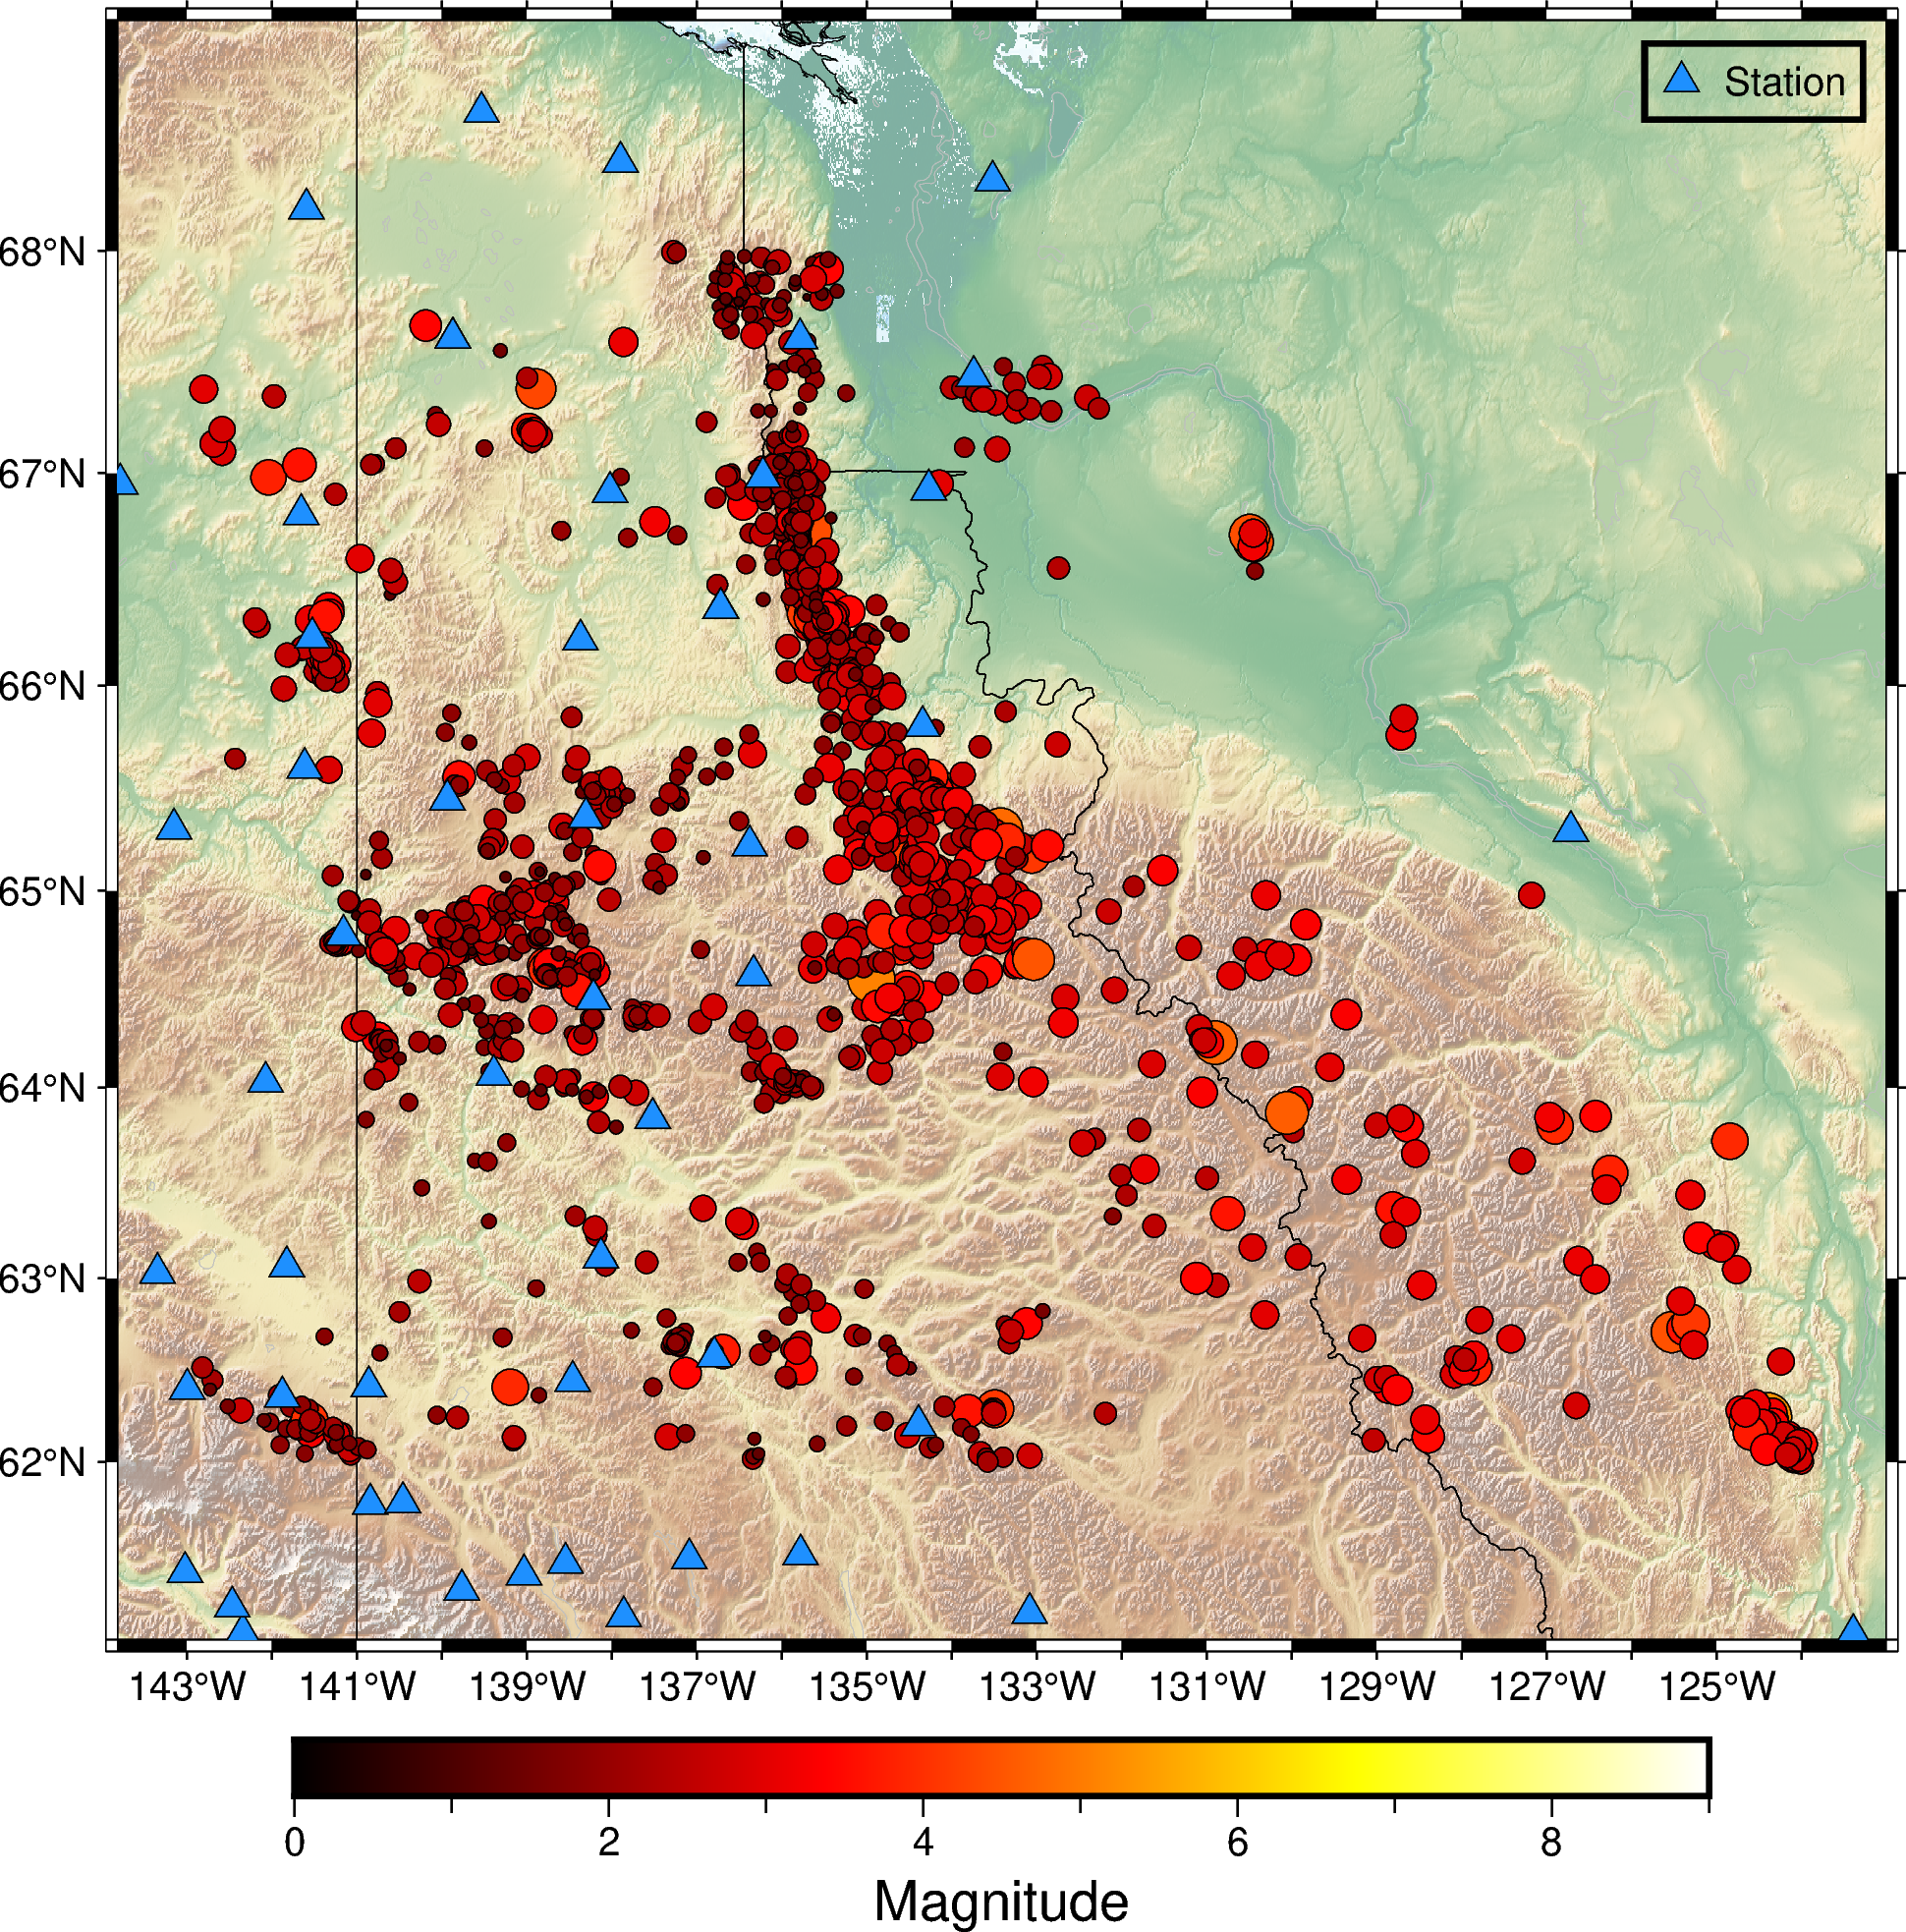

In [21]:
import pygmt
def region_event_station_map_grey(df_info, df_info_sta, figname="Cas_event_station_map.png",
                                  clon=None, colormap='geo'):
    res = "f"
    # Set the region
    region = [
        df_info['srcLon (deg)'].min() - 1,
        df_info['srcLon (deg)'].max() + 1,
        df_info['srcLat (deg)'].min() - 1,
        df_info['srcLat (deg)'].max() + 1,
    ]
    fig = pygmt.Figure()
    # Make color pallets
    pygmt.makecpt(
        cmap='gray',
        series='-8000/5000/1000',
        continuous=True
    )
    # Define etopo data file
    topo_data = "@earth_relief_30s"

    if not colormap:
        colormap = "hot"

    # Plot the topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection="M6i",
        cmap="geo",
        shading=True,
        transparency=50  # Set topography transparency to 50%
    )

    fig.coast(
        resolution=res,
        region=region,
        frame="a1f1",
        shorelines=["1/0.2p,black", "2/0.05p,gray"],
        borders=[1, 2],  # Plot state boundaries with thin lines
    )

    # Colorbar colormap
    pygmt.makecpt(cmap="hot", series=[
        0.0, 9.0])
    fig.colorbar(frame='af+l"Magnitude"')

    # Plot earthquakes
    fig.plot(
        x=df_info["srcLon (deg)"].values,
        y=df_info["srcLat (deg)"].values,
        size=0.08 * df_info["mag Sol"].values,
        color=df_info["mag Sol"].values,
        cmap=True,
        style="cc",
        pen="black",
        label="Earthquakes"
    )
    # Plot station
    fig.plot(
        x=df_info_sta["srcLon (deg)"].values,
        y=df_info_sta["srcLat (deg)"].values,
        style="t10p",
        color="dodgerblue",
        pen="black",
        label="Station",
    )
    fig.legend(position="JTR+jTR+o0.2c", box=True)
    fig.show()
    fig.savefig(figname, dpi=300)

# Test the function with your dataframes: df_info and df_info_sta
region_event_station_map_grey(event_df, station_df, figname="MacKenzie_map.png",
                      clon=None, colormap='geo')


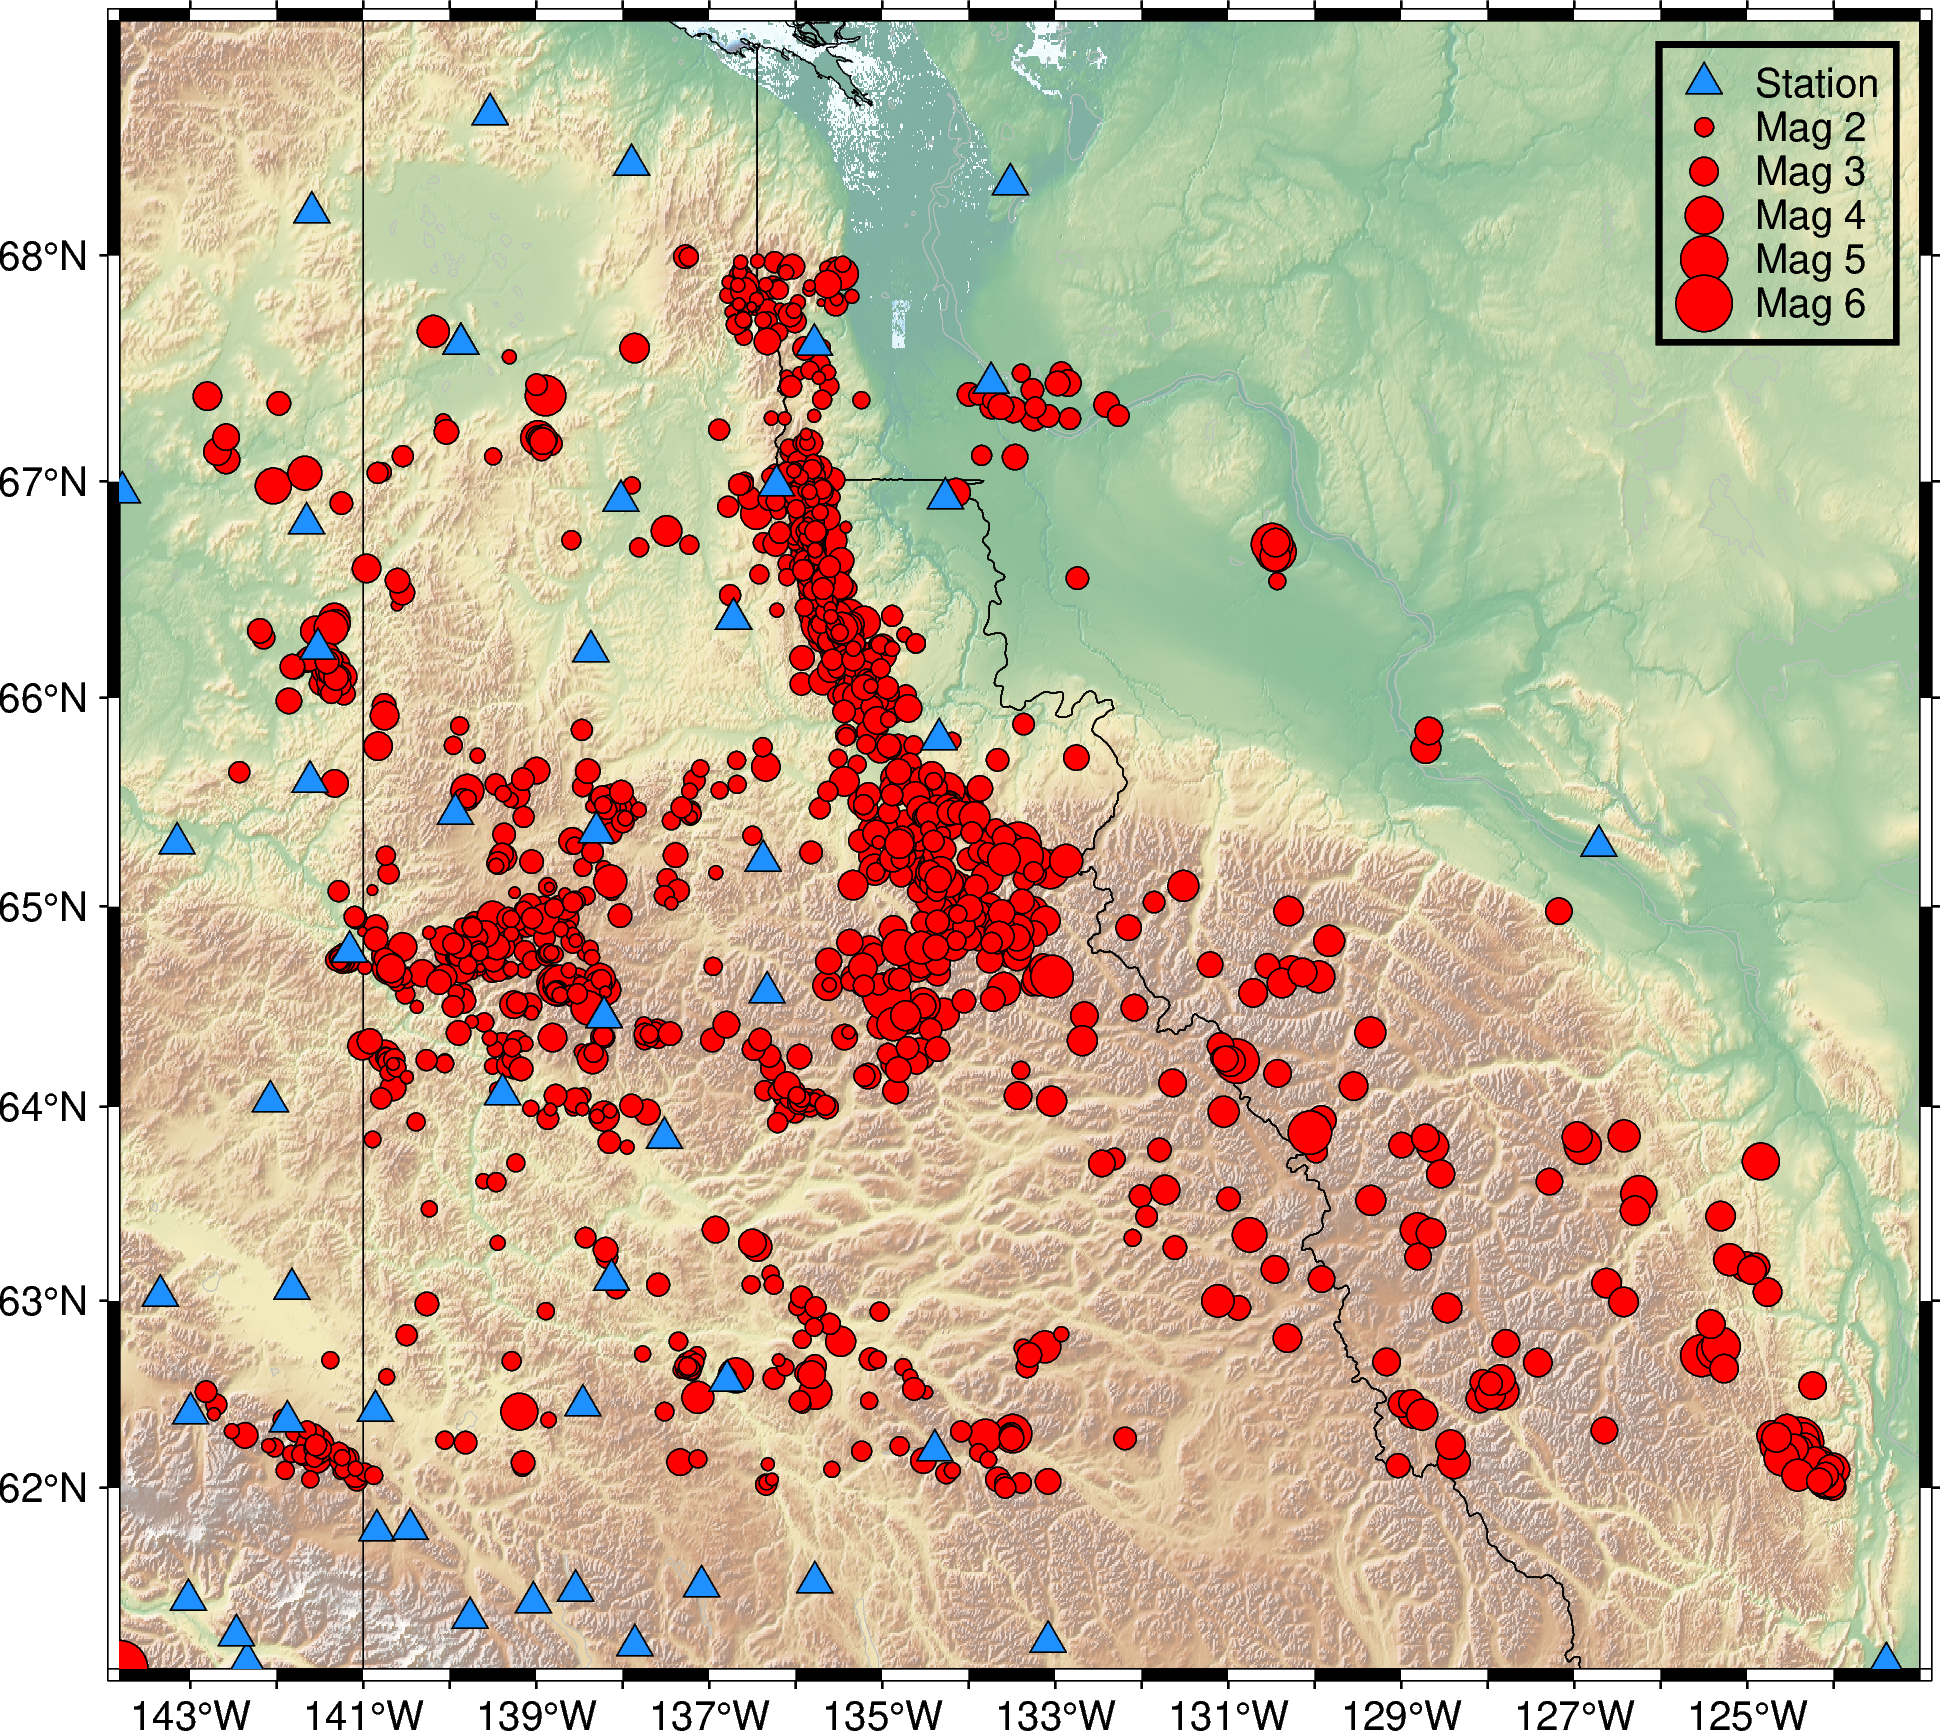

In [22]:

def region_event_station_map_grey(df_info, df_info_sta, figname="Cas_event_station_map.png",
                                  clon=None, colormap='geo'):
    res = "f"
    # Set the region
    region = [
        df_info['srcLon (deg)'].min() - 1,
        df_info['srcLon (deg)'].max() + 1,
        df_info['srcLat (deg)'].min() - 1,
        df_info['srcLat (deg)'].max() + 1,
    ]
    fig = pygmt.Figure()

    # Make color pallets for topography
    pygmt.makecpt(
        cmap='gray',
        series='-8000/5000/1000',
        continuous=True
    )
    
    # Define etopo data file
    topo_data = "@earth_relief_30s"

    # Plot the topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection="M6i",
        cmap="geo",
        shading=True,
        transparency=50  # Set topography transparency to 50%
    )

    fig.coast(
        resolution=res,
        region=region,
        frame="a1f1",
        shorelines=["1/0.2p,black", "2/0.05p,gray"],
        borders=[1, 2],  # Plot state boundaries with thin lines
    )

    # Plot earthquakes
    fig.plot(
        x=df_info["srcLon (deg)"].values,
        y=df_info["srcLat (deg)"].values,
        size=0.08 * df_info["mag Sol"].values,
        color='red',
        style="cc",
        pen="black"
    )
    
    # Plot station
    fig.plot(
        x=df_info_sta["srcLon (deg)"].values,
        y=df_info_sta["srcLat (deg)"].values,
        style="t10p",
        color="dodgerblue",
        pen="black",
        label="Station"
    )

    # Adding custom symbols for legend
    for mag, scale in zip([2, 3, 4, 5, 6], [0.16, 0.24, 0.32, 0.4, 0.48]):
        fig.plot(x=[region[0]], y=[region[2]], style=f"c{scale}c", color="red", pen="black", label=f"Mag {mag}")
    
    # Add legend
    fig.legend(position="JTR+jTR+o0.2c", box=True)

    # Show and save the figure
    fig.show()
    fig.savefig(figname, dpi=300)


# Test the function with your dataframes: df_info and df_info_sta
region_event_station_map_grey(event_df, station_df, figname="MacKenzie_map_1.png",
                              clon=None, colormap='geo')
